In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.utils import functions, path
from spectrome.brain import Brain


from spectrome.forward import ntf_local_stimulus as nt_stim
from spectrome.forward import ntf_local as nt_nostim
from spectrome.forward import ntf_local_stimulus as nt_stim

from scipy.io import loadmat
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection

from scipy.io import savemat
import pickle as pkl

In [2]:
##all the sessions data of EEG
data1=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_EEG_Sess1.mat")
data2=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_EEG_Sess2.mat")
data3=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_EEG_Sess3.mat")
data4=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_EEG_Sess4.mat")


##all the sessions mi 
sess1_mi_avg=data1['Avg_MI_EEG_DK']
sess2_mi_avg=data2['Avg_MI_EEG_DK']
sess3_mi_avg=data3['Avg_MI_EEG_DK']
sess4_mi_avg=data4['Avg_MI_EEG_DK']

##all the sessions resting state
sess1_rest_avg=data1['Avg_RS1_EEG_DK']
sess2_rest_avg=data2['Avg_RS1_EEG_DK']
sess3_rest_avg=data3['Avg_RS1_EEG_DK']
sess4_rest_avg=data4['Avg_RS1_EEG_DK']

##all the sessions baseline
sess1_base_avg=data1['Avg_Baseline_EEG_DK']
sess2_base_avg=data2['Avg_Baseline_EEG_DK']
sess3_base_avg=data3['Avg_Baseline_EEG_DK']
sess4_base_avg=data4['Avg_Baseline_EEG_DK']


In [3]:
scores=np.squeeze(loadmat("../../../Performance_Sess4.mat")['Performance_Sess4'])
df=pd.read_excel('../../../spectrome-bci/spectrome/ListROIs_DK.xlsx')

In [4]:
scores

array([89.3 , 38.1 , 86.1 , 63.9 , 88.9 , 56.7 , 70.  , 60.  , 66.1 ,
       63.3 , 53.9 , 77.2 , 69.17, 80.  , 61.1 , 71.  , 73.  , 68.33,
       56.67])

In [5]:
# df.head(10)

In [6]:
fvec=np.squeeze(data1["Freqs"])[3:30]

In [7]:
fvec

array([ 2.99879993,  3.9983999 ,  4.99799988,  5.99759985,  6.99719983,
        7.9967998 ,  8.99639978,  9.99599976, 10.99559973, 11.99519971,
       12.99479968, 13.99439966, 14.99399963, 15.99359961, 16.99319958,
       17.99279956, 18.99239954, 19.99199951, 20.99159949, 21.99119946,
       22.99079944, 23.99039941, 24.98999939, 25.98959937, 26.98919934,
       27.98879932, 28.98839929])

In [8]:
all_regions=[]
all_regions_idx=[]
for i,r in df.iterrows():
    all_regions_idx.append(i)
    all_regions.append(r['ROI'].strip("'"))

In [11]:
##modeled data
x_mi_all={}
x_base_all={}
x_rest_all={}

for num in range(1, 5):
    x_mi_all[num]=np.zeros((68, 10, 19))
    x_base_all[num]=np.zeros((68, 10, 19))
    x_rest_all[num]=np.zeros((68, 10, 19))
    
    for i in range(19):
        mi_fname = f'../bci_results_apd/bci_results/eeg/sess{num}/mi_allsubs_f/mi_nostim_mse_db_fvec330_{i}.p'
        with open(mi_fname, 'rb') as f:
            x_mi_all[num][:,:,i]=np.array(pkl.load(f))

        base_fname = f'../bci_results_apd/bci_results/eeg/sess{num}/baseline_allsubs_f/baseline_nostim_mse_db_fvec330_{i}.p'
        with open(base_fname, 'rb') as f:
            x_base_all[num][:,:,i] = np.array(pkl.load(f))
        
        rest_fname = f'../bci_results_apd/bci_results/eeg/sess{num}/rs1_allsubs_f0/rs1_nostim_mse_db_fvec330_{i}.p'
        with open(rest_fname, 'rb') as f:
            x_rest_all[num][:,:,i]=np.array(pkl.load(f))


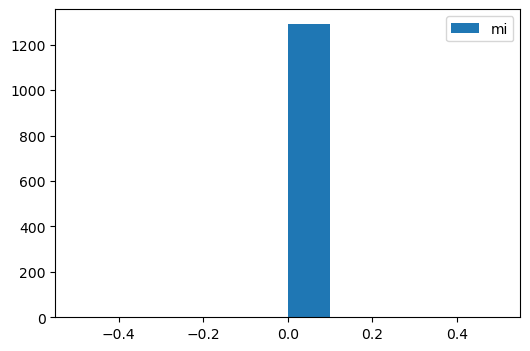

In [14]:
plt.figure(figsize=(6,4))
plt.hist(x_rest_all[4][:,4,:].flatten(), label='mi')
plt.legend()
plt.show()


### condition effect analysis for each parameters across subject in each session

In [29]:
#to store p-values--(gei, gii, tau_e, tau_i)-across all subjects/performers
### for MI V. Rest
##for each region across subjects
sess=1
pval_all_reg_top = np.zeros((len(all_regions_idx), 4))
for i in range(len(all_regions_idx)):
    pval_all_reg_top[i,0]=wilcoxon(x_mi_all[sess][all_regions_idx[i],0,:],x_rest_all[sess][all_regions_idx[i],0,:])[1] #gei
    pval_all_reg_top[i,1]=wilcoxon(x_mi_all[sess][all_regions_idx[i],1,:],x_rest_all[sess][all_regions_idx[i],1,:])[1] #gii
    pval_all_reg_top[i,2]=wilcoxon(x_mi_all[sess][all_regions_idx[i],2,:],x_rest_all[sess][all_regions_idx[i],2,:])[1] #tau_e
    pval_all_reg_top[i,3]=wilcoxon(x_mi_all[sess][all_regions_idx[i],3,:],x_rest_all[sess][all_regions_idx[i],3,:])[1] #tau_i

# FDR-corrected p-values 
pfdr=np.zeros((len(all_regions_idx), 4))
for i in range(4):
    pfdr[:,i]=fdrcorrection(pval_all_reg_top[:, i])[1]

significant_gei= np.where(pfdr[:,0]<0.05)[0]
significant_gii= np.where(pfdr[:,1]<0.05)[0]
significant_tau_e= np.where(pfdr[:,2]<0.05)[0]
significant_tau_i= np.where(pfdr[:,3]<0.05)[0]

print("Significant ROIs for gei (pfdr <0.05):", [all_regions[i] for i in significant_gei])
print("Significant ROIs for gii (pfdr < 0.05):", [all_regions[i] for i in significant_gii])
print("Significant ROIs for tau_e (pfdr < 0.05):", [all_regions[i] for i in significant_tau_e])
print("Significant ROIs for tau_i (pfdr < 0.05):", [all_regions[i]  for i in significant_tau_i])

#FDR-corrected p-values matrix for inspection
# print("FDR Corrected p-values matrix for Top Performers:\n", pfdr)

Significant ROIs for gei (pfdr <0.05): []
Significant ROIs for gii (pfdr < 0.05): []
Significant ROIs for tau_e (pfdr < 0.05): []
Significant ROIs for tau_i (pfdr < 0.05): []


In [26]:
unique_values = set(significant_gei) | set(significant_gii) | set(significant_tau_e)
print("Total values:", len(unique_values))

Total values: 9


In [29]:
#to store p-values--(gei, gii, tau_e, tau_i)-across all subjects/performers
### for MI V. Rest
##for each subject across regions
sess=4
pval_all_subs = np.zeros((19, 4))
for i in range(19):
    pval_all_subs[i,0]=wilcoxon(x_mi_all[sess][:,0,i],x_rest_all[sess][:,0,i])[1] #gei
    pval_all_subs[i,1]=wilcoxon(x_mi_all[sess][:,1,i],x_rest_all[sess][:,1,i])[1] #gii
    pval_all_subs[i,2]=wilcoxon(x_mi_all[sess][:,2,i],x_rest_all[sess][:,2,i])[1] #tau_e
    pval_all_subs[i,3]=wilcoxon(x_mi_all[sess][:,3,i],x_rest_all[sess][:,3,i])[1] #tau_i

# FDR-corrected p-values 
pfdr=np.zeros((19, 4))
for i in range(4):
    pfdr[:,i]=fdrcorrection(pval_all_subs[:, i])[1]


significant_gei= np.where(pfdr[:,0]<0.05)[0]
significant_gii= np.where(pfdr[:,1]<0.05)[0]
significant_tau_e= np.where(pfdr[:,2]<0.05)[0]
significant_tau_i= np.where(pfdr[:,3]<0.05)[0]

# print("Significant ROIs for gei (pfdr <0.05):", [all_regions[i] for i in significant_gei])
# print("Significant ROIs for gii (pfdr < 0.05):", [all_regions[i] for i in significant_gii])
# print("Significant ROIs for tau_e (pfdr < 0.05):", [all_regions[i] for i in significant_tau_e])
# print("Significant ROIs for tau_i (pfdr < 0.05):", [all_regions[i]  for i in significant_tau_i])

#FDR-corrected p-values matrix for inspection
# print("FDR Corrected p-values matrix for Top Performers:\n", pfdr)

In [30]:
significant_gii, significant_gei

(array([ 2,  3,  5,  8, 10, 11, 12, 13, 14, 15, 17, 18], dtype=int64),
 array([ 2,  3,  4,  5,  6, 10, 11, 12, 13, 17], dtype=int64))

### (MI-Rest)/Rest

In [30]:
##tau_e
sess1_mi_rest_tau_e=[[] for _ in range(68)]
sess2_mi_rest_tau_e=[[] for _ in range(68)]
sess3_mi_rest_tau_e=[[] for _ in range(68)]
sess4_mi_rest_tau_e=[[] for _ in range(68)]


for k in range(68):
    for j in range(19):
        mi_rest1_tau_e=((x_mi_all[1][k,2,j])-(x_rest_all[1][k,2,j]))/(x_rest_all[1][k,2,j])
        sess1_mi_rest_tau_e[k].append(mi_rest1_tau_e)
        mi_rest2_tau_e=((x_mi_all[2][k,2,j])-(x_rest_all[2][k,2,j]))/(x_rest_all[2][k,2,j])
        sess2_mi_rest_tau_e[k].append(mi_rest2_tau_e)
        mi_rest3_tau_e=((x_mi_all[3][k,2,j])-(x_rest_all[3][k,2,j]))/(x_rest_all[3][k,2,j])
        sess3_mi_rest_tau_e[k].append(mi_rest3_tau_e)
        mi_rest4_tau_e=((x_mi_all[4][k,2,j])-(x_rest_all[4][k,2,j]))/(x_rest_all[4][k,2,j])
        sess4_mi_rest_tau_e[k].append(mi_rest4_tau_e)

In [31]:
##gii
sess1_mi_rest_gii=[[] for _ in range(68)]
sess2_mi_rest_gii=[[] for _ in range(68)]
sess3_mi_rest_gii=[[] for _ in range(68)]
sess4_mi_rest_gii=[[] for _ in range(68)]

 
for k in range(68):
    for j in range(19):
        mi_rest1_gii=((x_mi_all[1][k,1,j])-(x_rest_all[1][k,1,j]))/(x_rest_all[1][k,1,j])
        sess1_mi_rest_gii[k].append(mi_rest1_gii)
        mi_rest2_gii=((x_mi_all[2][k,1,j])-(x_rest_all[2][k,1,j]))/(x_rest_all[2][k,1,j])
        sess2_mi_rest_gii[k].append(mi_rest2_gii)
        mi_rest3_gii=((x_mi_all[3][k,1,j])-(x_rest_all[3][k,1,j]))/(x_rest_all[3][k,1,j])
        sess3_mi_rest_gii[k].append(mi_rest3_gii)
        mi_rest4_gii=((x_mi_all[4][k,1,j])-(x_rest_all[4][k,1,j]))/(x_rest_all[4][k,1,j])
        sess4_mi_rest_gii[k].append(mi_rest4_gii)

###  session by session progress in significant regions, starting from session-4

In [37]:
def find_mean(data):
    return [np.mean(lst) for lst in data]

def plot_violin(data, means, param, region, state):
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=data, density_norm='width', inner=None, palette="muted", orient="v")
    sns.stripplot(data=data, color="black", size=5, jitter=False, orient="v")

    for i, mean in enumerate(means):
        plt.scatter(i, mean, color="red", zorder=3, label="Mean" if i == 0 else "")
    
    plt.plot(range(len(means)), means, color="blue", linestyle="-", zorder=2)
    plt.xlabel("Sessions", fontsize=12)
    plt.ylabel(f"{param}", fontsize=12)
    plt.title(f"EEG-{state} in {region}", fontsize=14)
    plt.xticks(ticks=range(len(data)), labels=range(1, len(data) + 1), fontsize=10)
    plt.grid(axis='y', linestyle='', alpha=0)  
    plt.yticks(fontsize=10)  
    plt.legend(loc="upper right")
    plt.show()

In [38]:

def find_mean(data):
    return [np.mean(lst) for lst in data]

def plot_violin(data, means, param, region, state):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.violinplot(data=data, ax=ax, inner=None, palette="muted", orient="v", linewidth=1)
    sns.stripplot(data=data, ax=ax, color="black", size=4.5, jitter=False, orient="v")

    for i, mean in enumerate(means):
        ax.scatter(i, mean, color="red", zorder=3, label="Mean" if i==0 else "")
        
    # for i, mean in enumerate(means):
    #         ax.hlines(y=mean, xmin=i - 0.25, xmax=i + 0.25, color='red', linewidth=2, zorder=4)
    #         # ax.scatter(i, mean, color="red", zorder=5, label="Mean" if i == 0 else "")

    ax.plot(range(len(means)), means, color="blue", linestyle="-", zorder=2)
    ax.set_xlabel("Sessions", fontsize=12, weight='bold')
    ax.set_ylabel(param, fontsize=12, weight='bold')
    ax.set_title(f"EEG - {state} in {region}", fontsize=14, weight='bold')

    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(range(1, len(data) + 1), fontsize=16)
    ax.set_yticks(ax.get_yticks())  
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(False)


    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color("black")

    ax.legend()
    plt.tight_layout()
    plt.show()


In [39]:
##tau_e
cnt=0
for i in significant_tau_e:
    cnt+=1
    print(all_regions[i])
print(cnt)

bankssts L
caudalanteriorcingulate L
caudalanteriorcingulate R
caudalmiddlefrontal L
caudalmiddlefrontal R
cuneus L
frontalpole L
frontalpole R
fusiform R
inferiorparietal L
inferiortemporal R
11


In [40]:
# sess3_mi_rest_tau_e[63]

In [41]:

# ##for tau_e--(MI-Rest)/Rest
# def main():
#     for i in significant_tau_e:
#       data = [sess1_mi_rest_tau_e[i],sess2_mi_rest_tau_e[i],sess3_mi_rest_tau_e[i],sess4_mi_rest_tau_e[i]]
#       means = find_mean(data)
#       parameter="tau_e"
#       state="(MI-Rest)/Rest"
#       plot_violin(data, means, parameter, all_regions[i],state)

# if __name__ == "__main__":
#     main()


In [42]:
for idx, region in enumerate(all_regions):
    print(idx, all_regions[idx])

0 bankssts L
1 bankssts R
2 caudalanteriorcingulate L
3 caudalanteriorcingulate R
4 caudalmiddlefrontal L
5 caudalmiddlefrontal R
6 cuneus L
7 cuneus R
8 entorhinal L
9 entorhinal R
10 frontalpole L
11 frontalpole R
12 fusiform L
13 fusiform R
14 inferiorparietal L
15 inferiorparietal R
16 inferiortemporal L
17 inferiortemporal R
18 insula L
19 insula R
20 isthmuscingulate L
21 isthmuscingulate R
22 lateraloccipital L
23 lateraloccipital R
24 lateralorbitofrontal L
25 lateralorbitofrontal R
26 lingual L
27 lingual R
28 medialorbitofrontal L
29 medialorbitofrontal R
30 middletemporal L
31 middletemporal R
32 paracentral L
33 paracentral R
34 parahippocampal L
35 parahippocampal R
36 parsopercularis L
37 parsopercularis R
38 parsorbitalis L
39 parsorbitalis R
40 parstriangularis L
41 parstriangularis R
42 pericalcarine L
43 pericalcarine R
44 postcentral L
45 postcentral R
46 posteriorcingulate L
47 posteriorcingulate R
48 precentral L
49 precentral R
50 precuneus L
51 precuneus R
52 ros

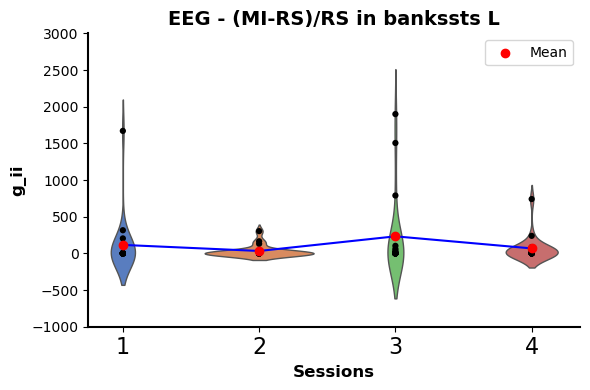

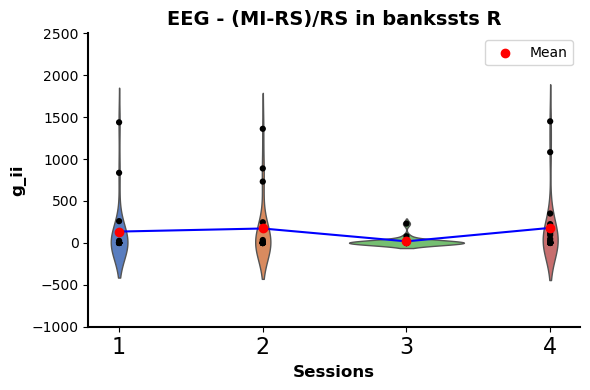

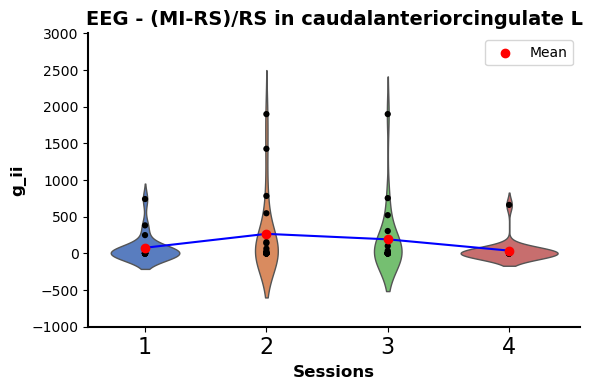

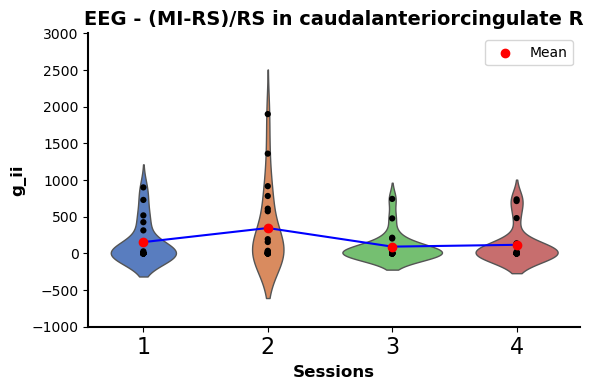

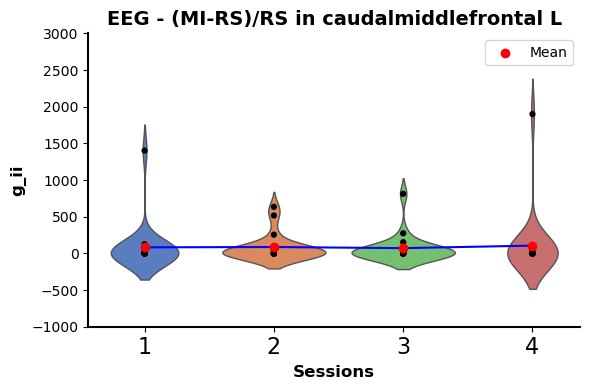

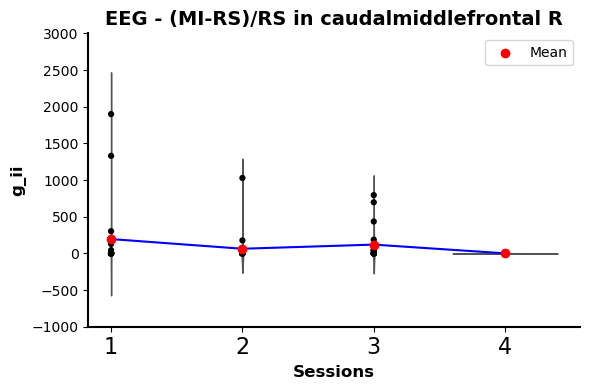

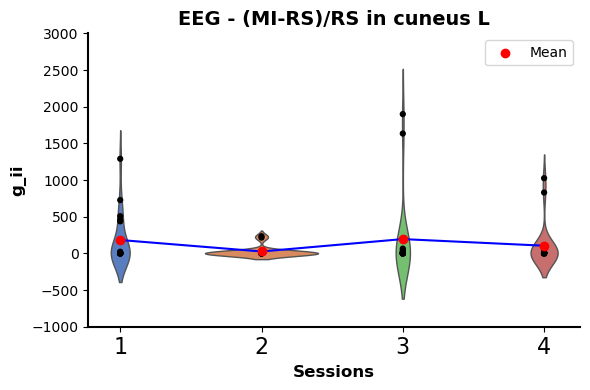

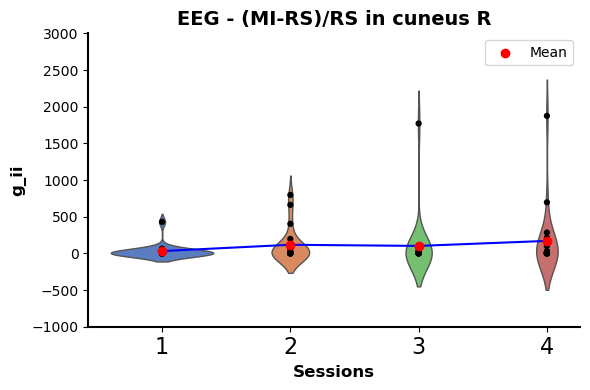

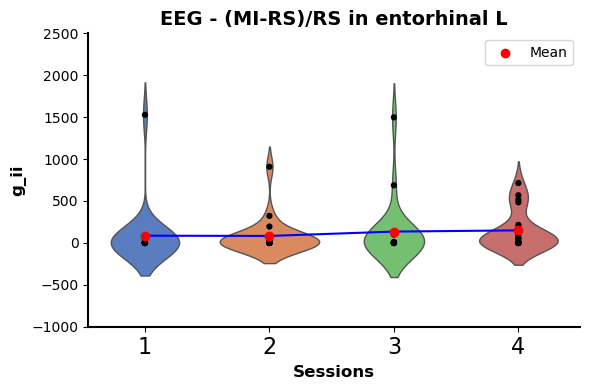

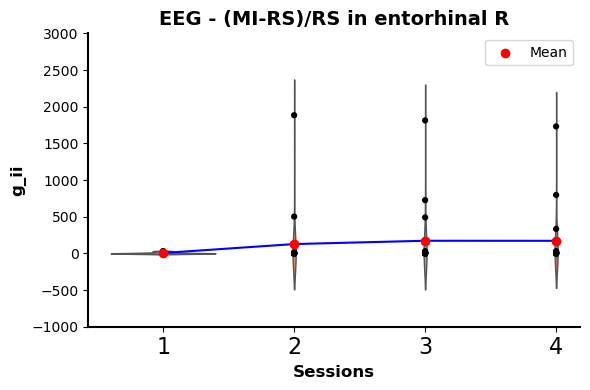

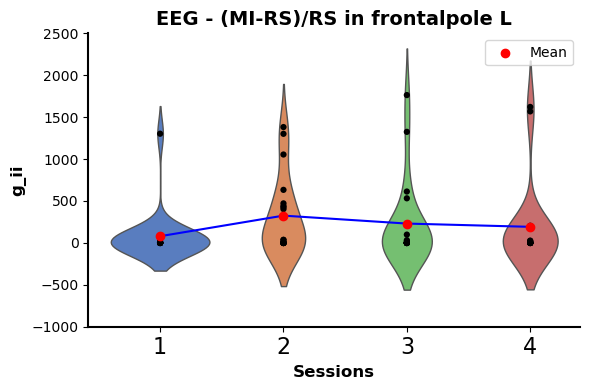

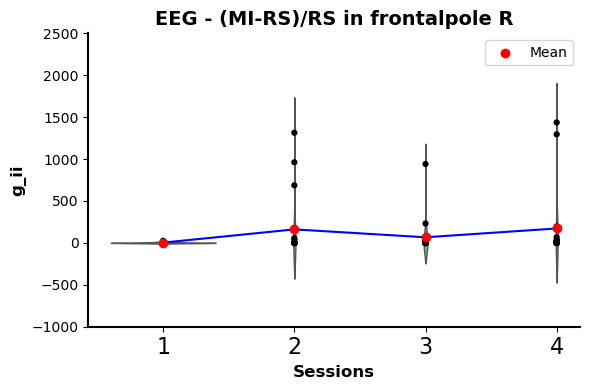

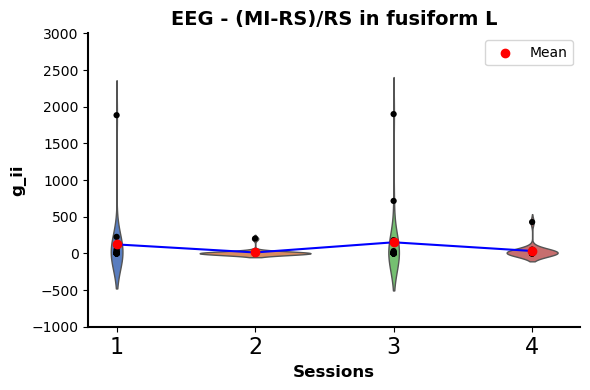

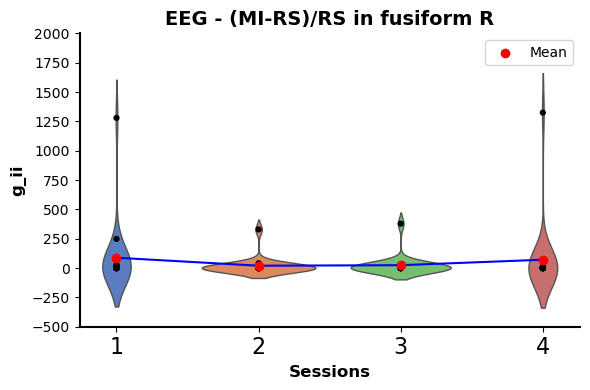

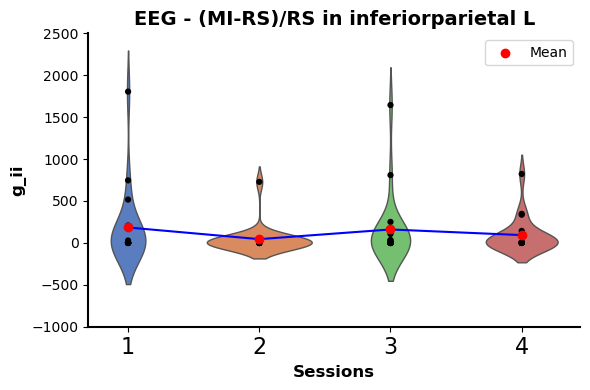

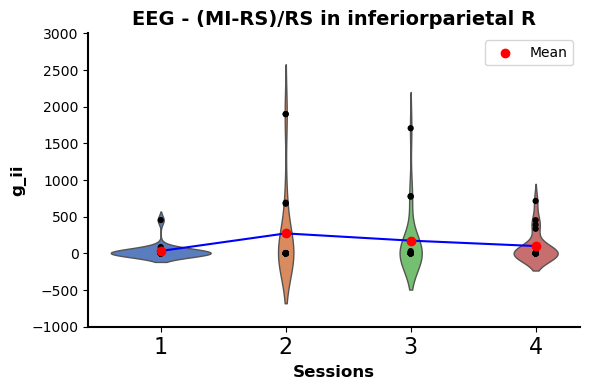

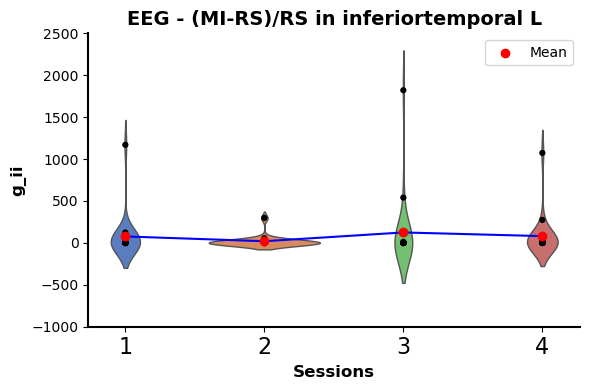

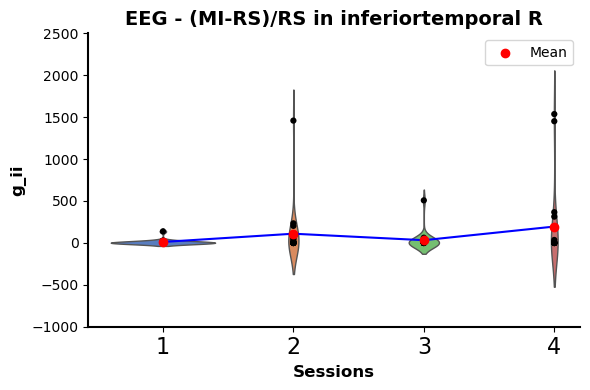

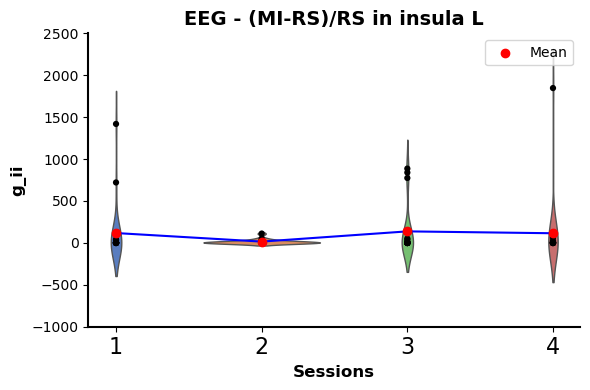

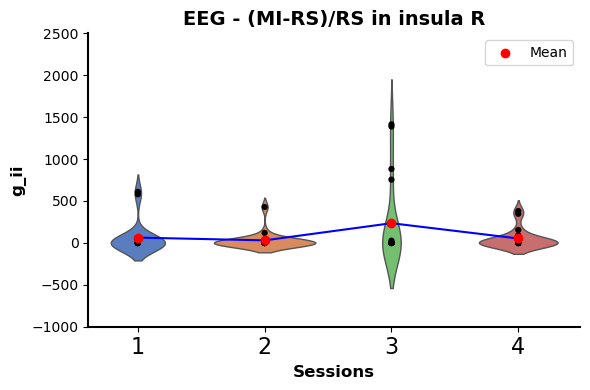

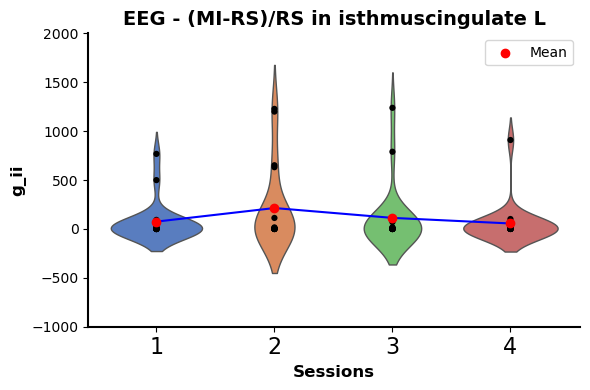

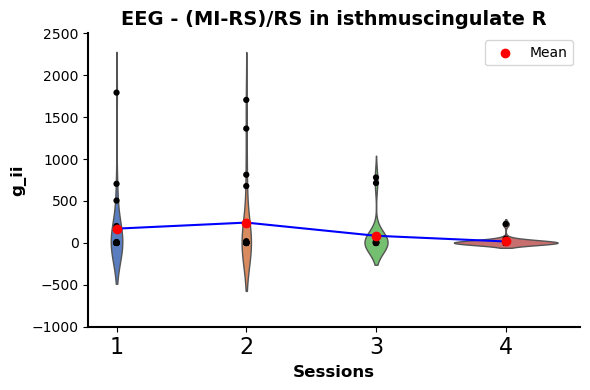

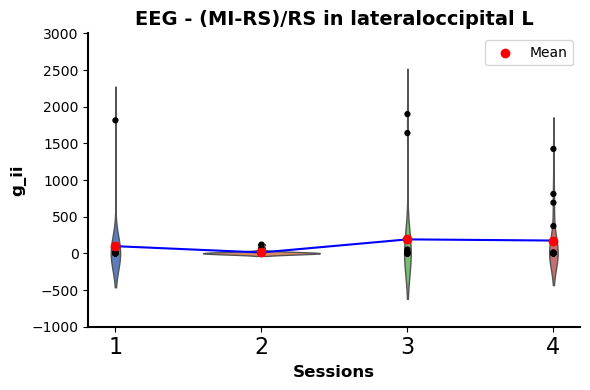

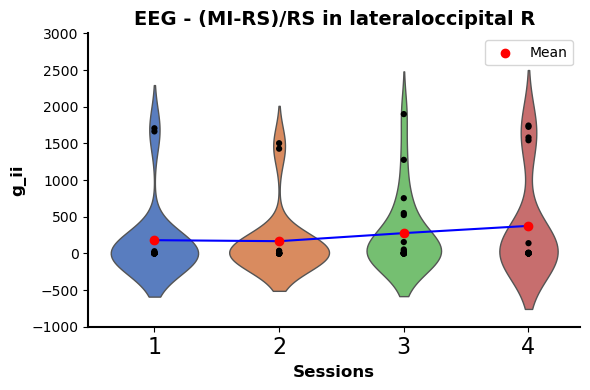

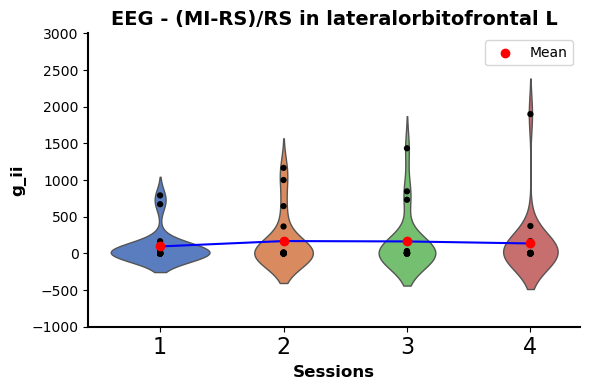

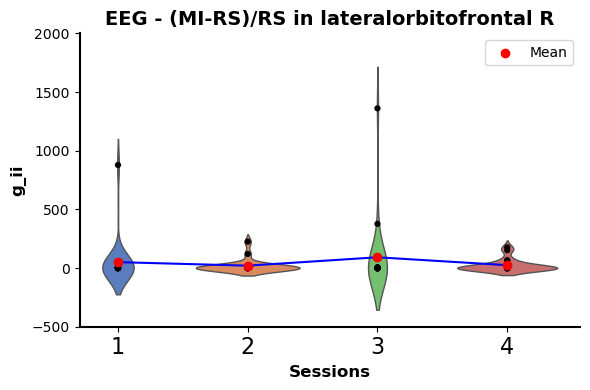

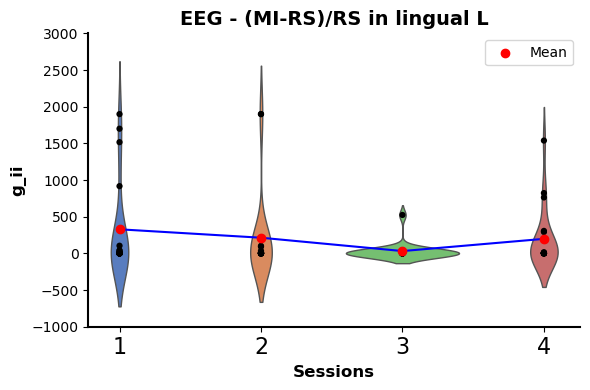

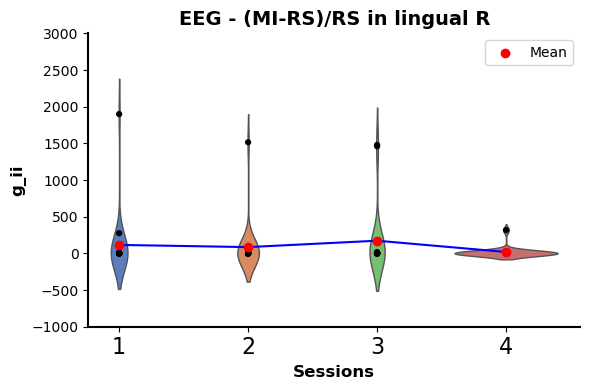

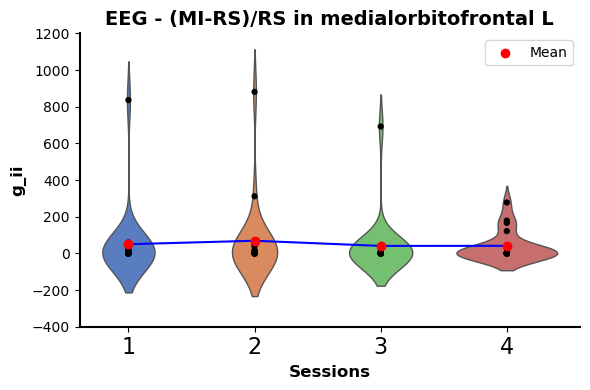

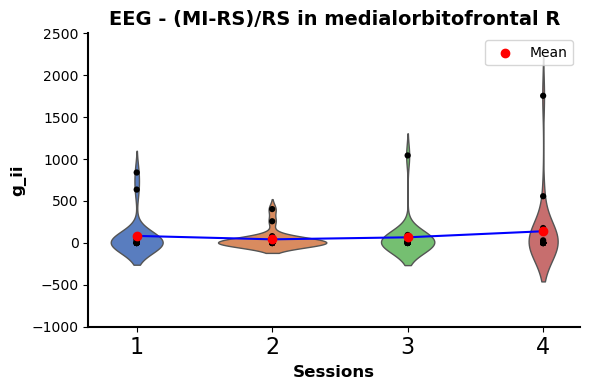

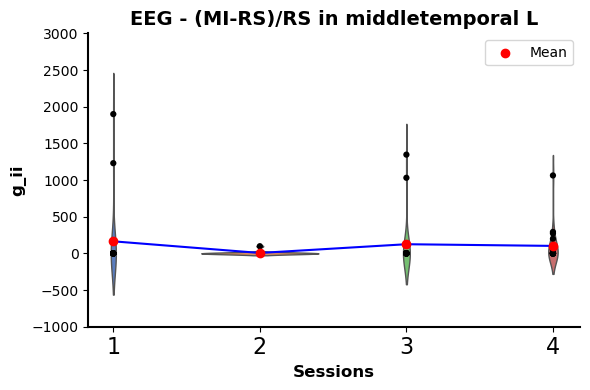

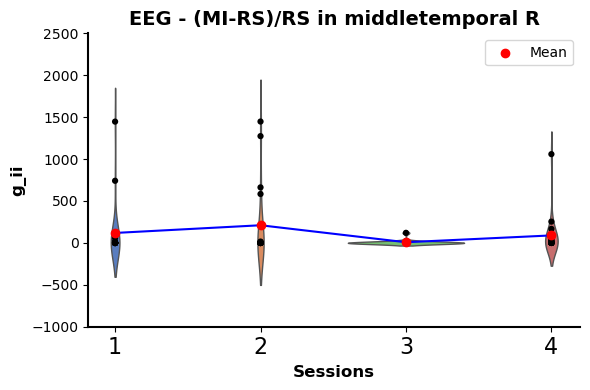

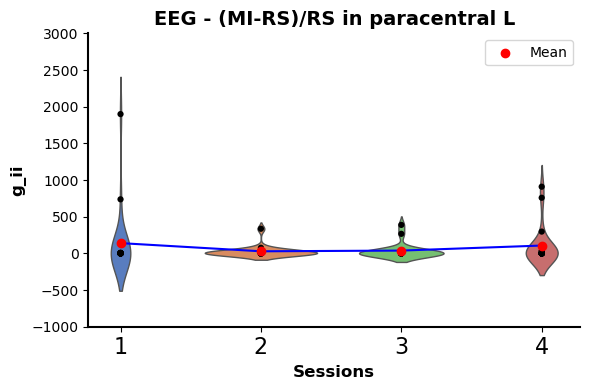

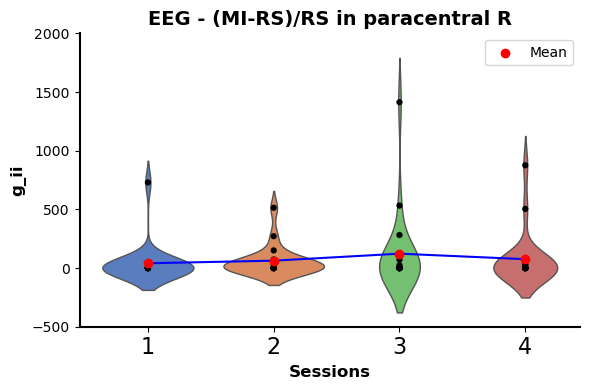

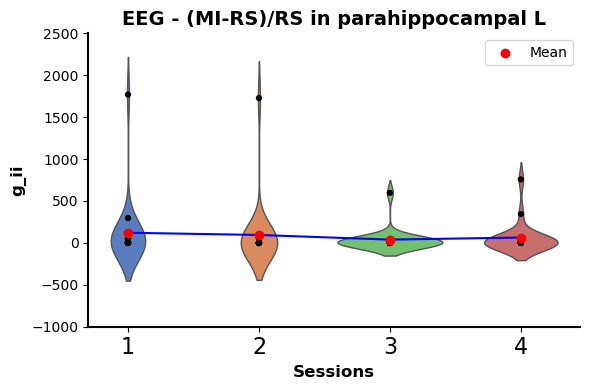

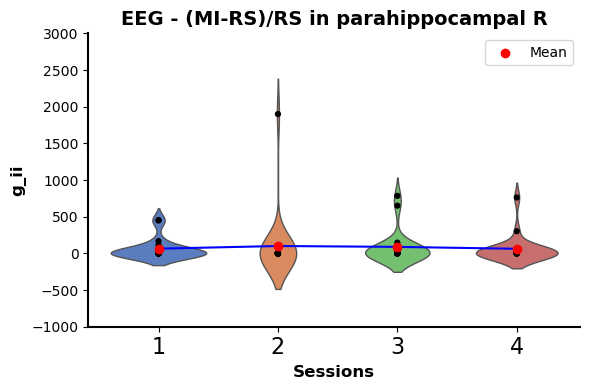

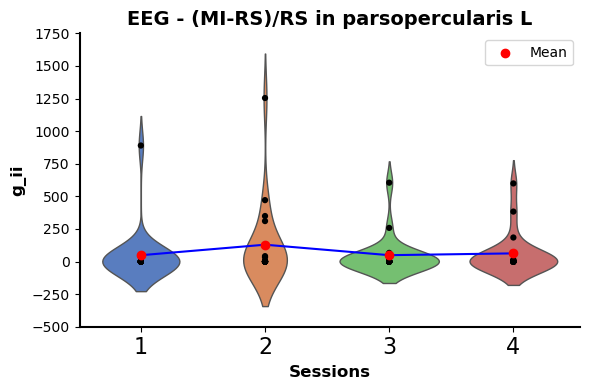

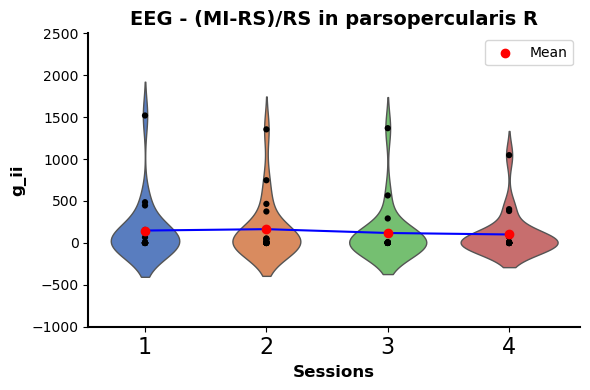

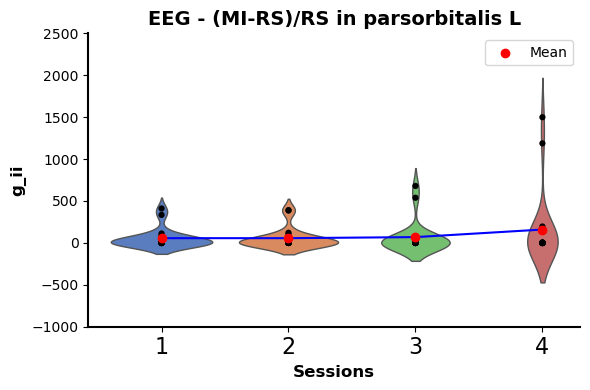

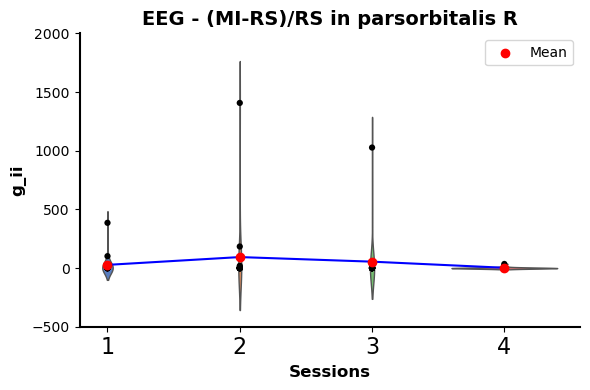

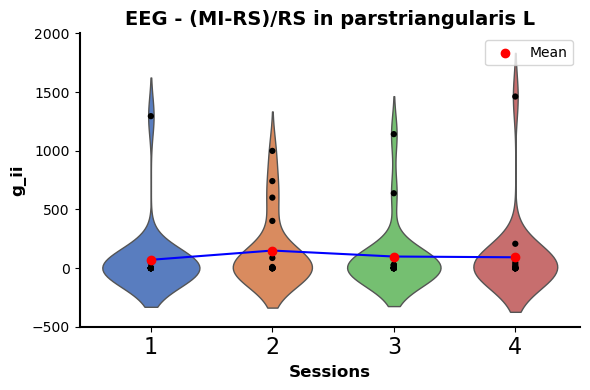

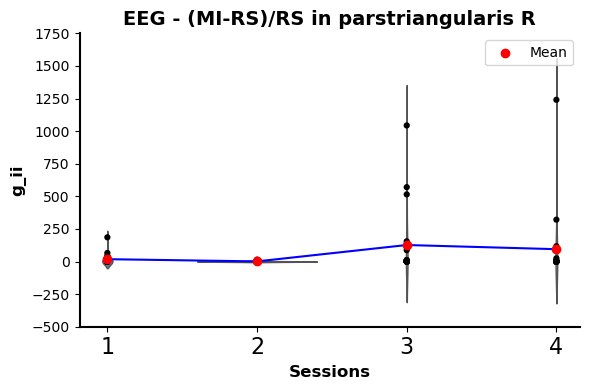

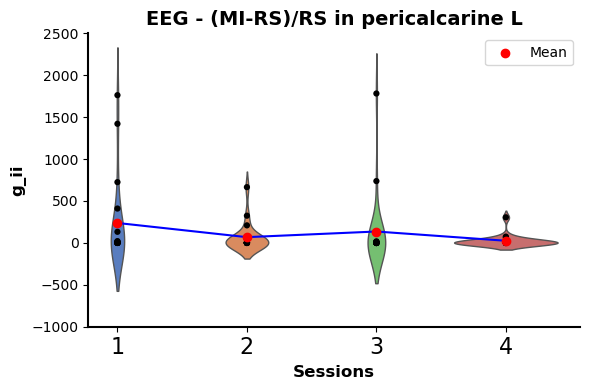

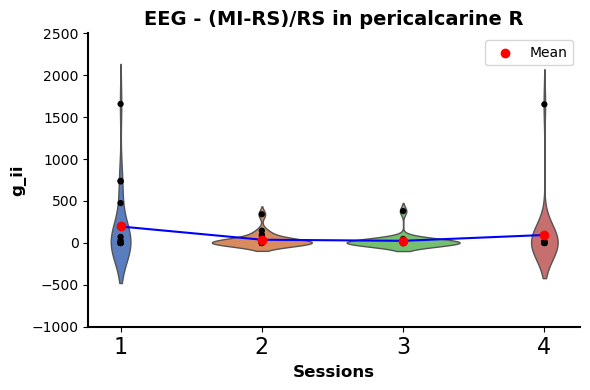

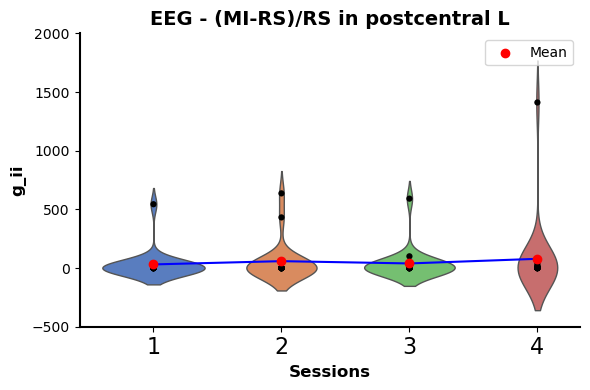

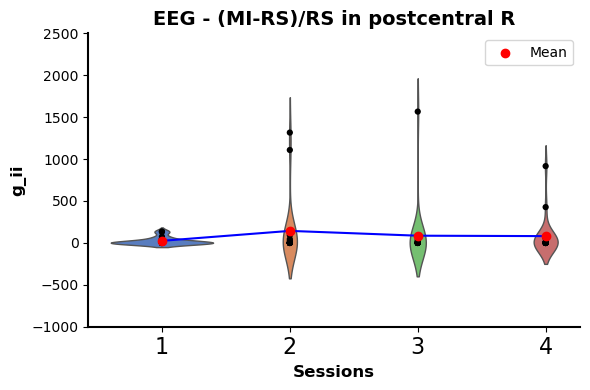

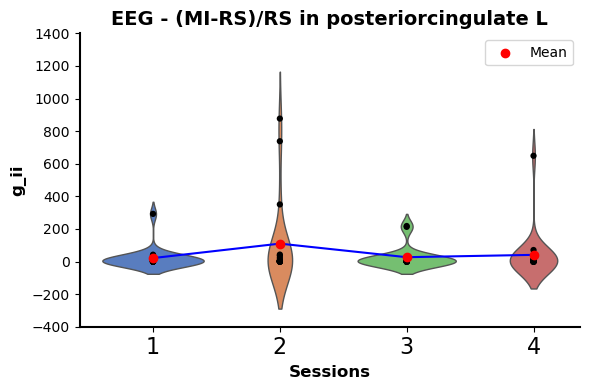

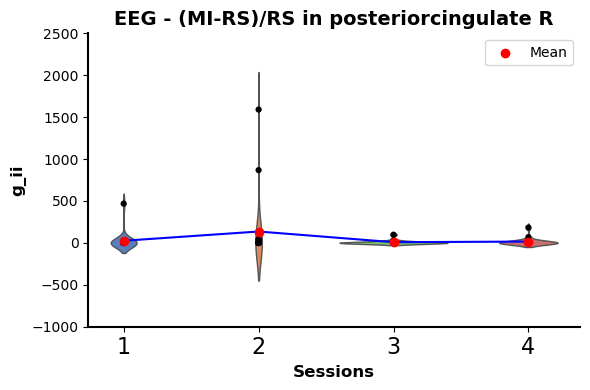

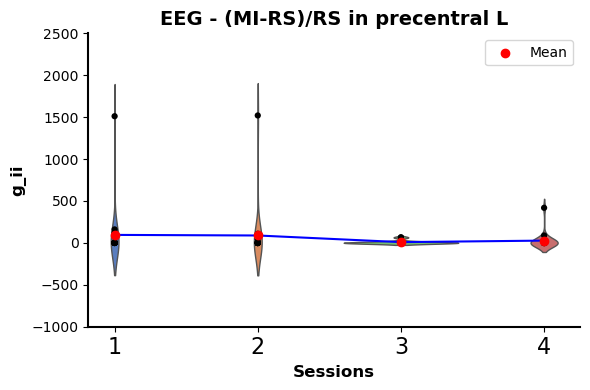

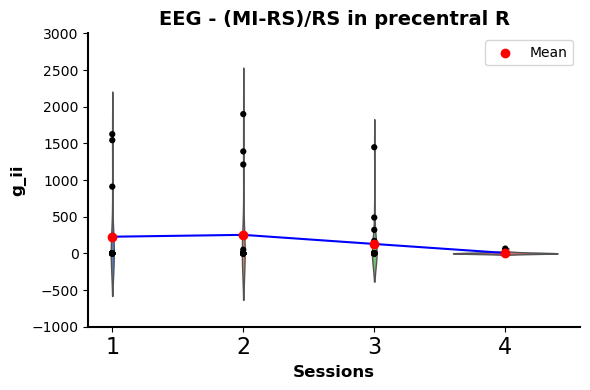

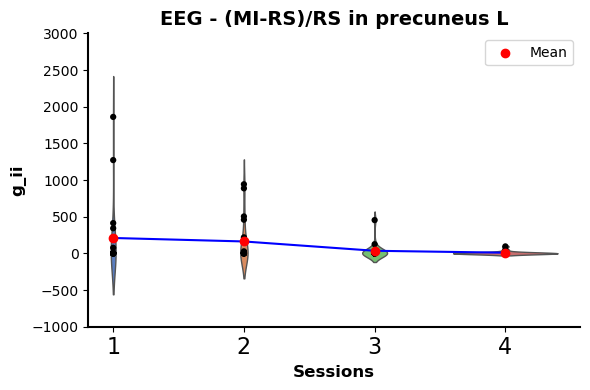

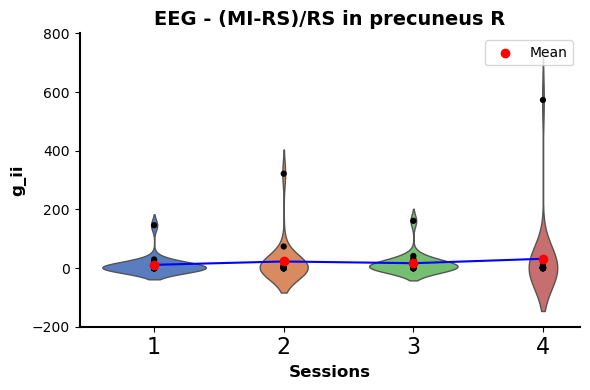

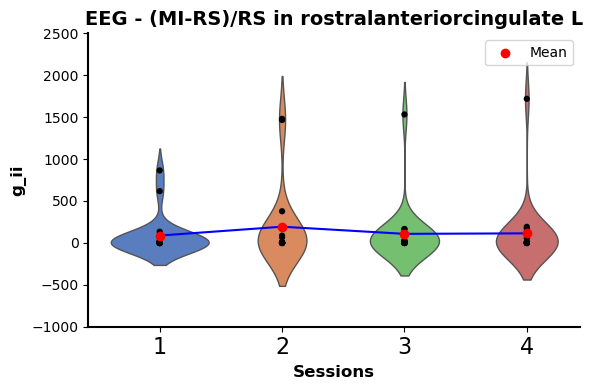

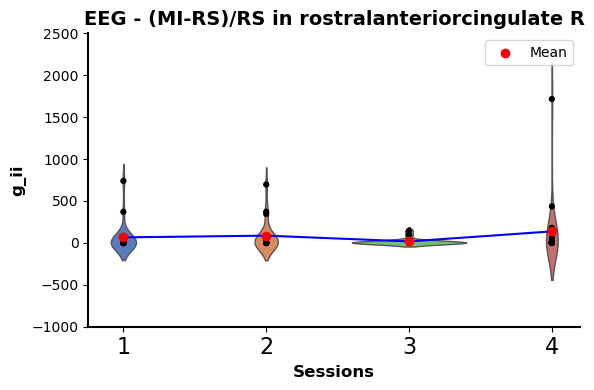

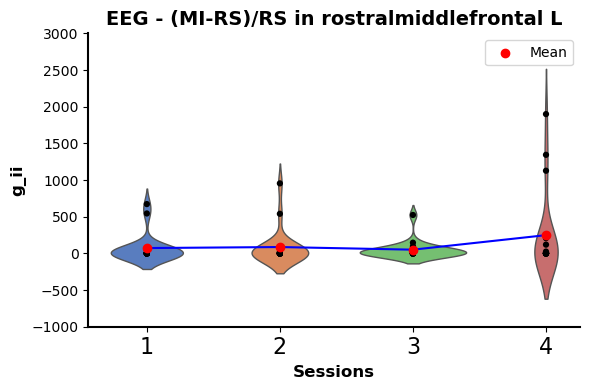

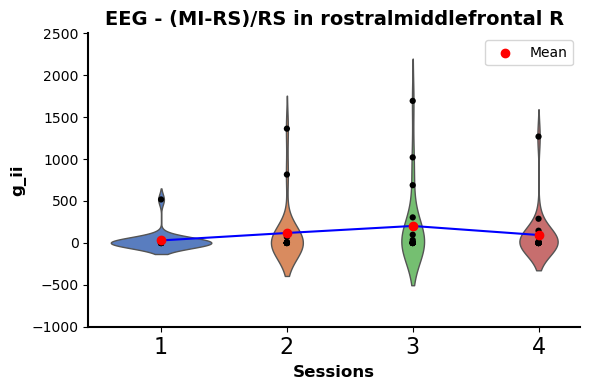

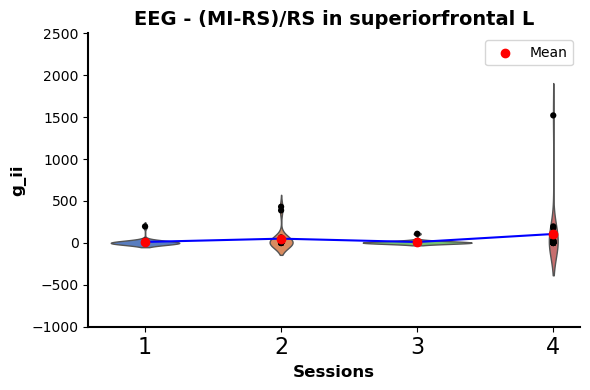

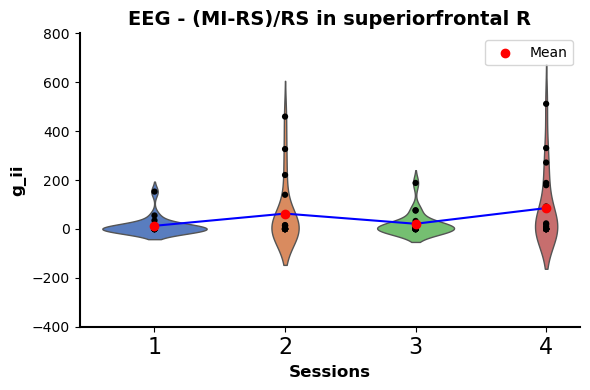

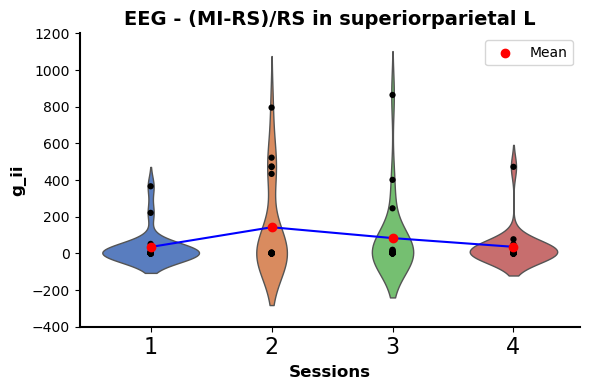

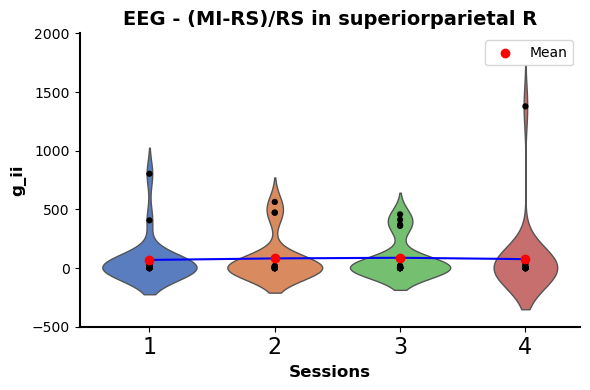

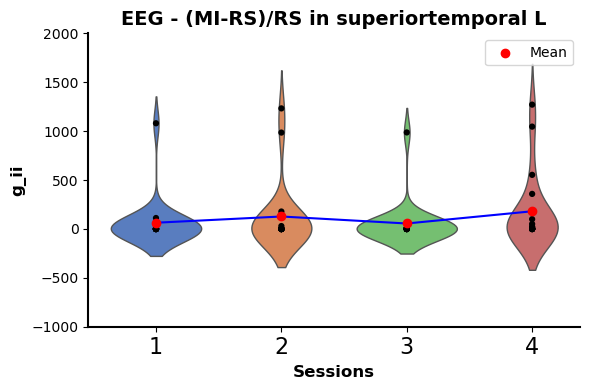

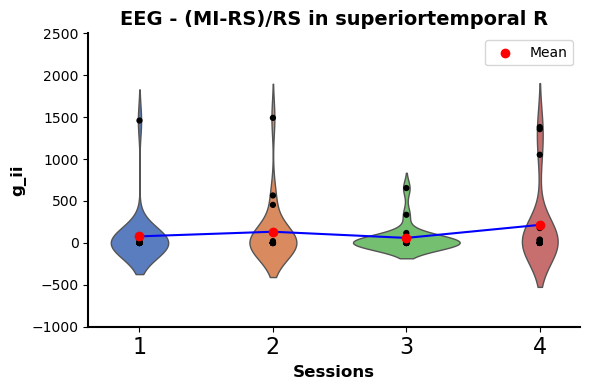

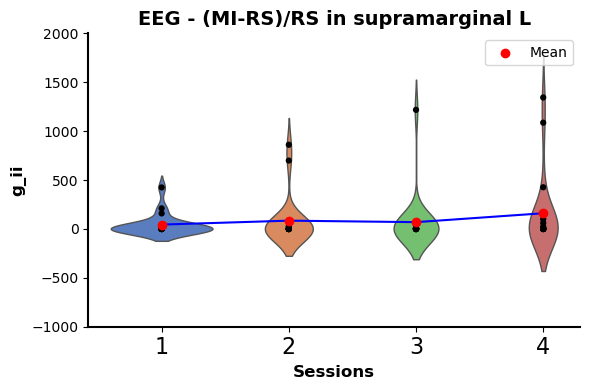

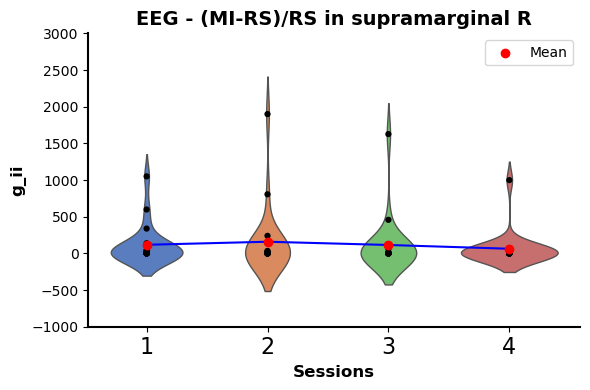

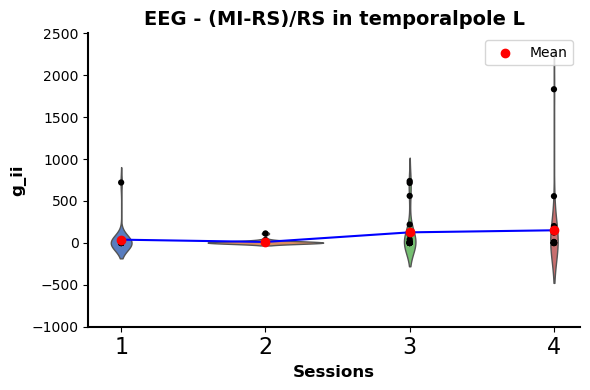

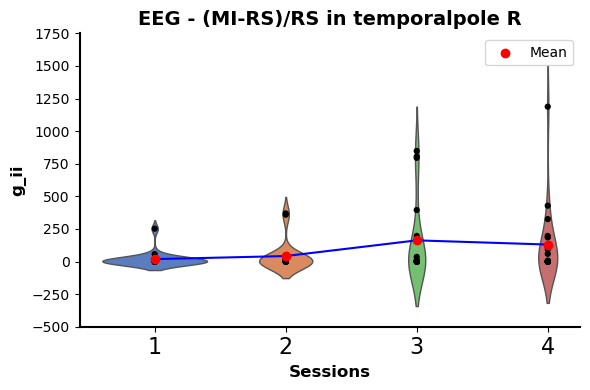

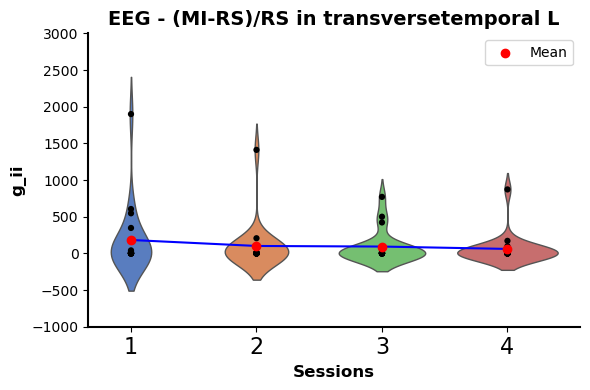

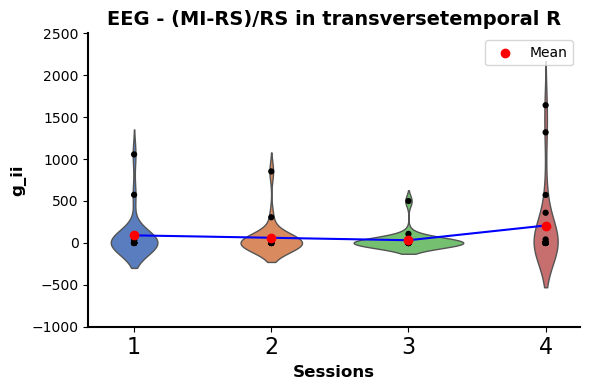

In [43]:
# indices=[7,31,32,44,48,58,20,21]
##for gii--(MI-Rest)/Rest
def main():
    for i in all_regions_idx:
      data = [sess1_mi_rest_gii[i],sess2_mi_rest_gii[i],sess3_mi_rest_gii[i],sess4_mi_rest_gii[i]]
      means = find_mean(data)
      parameter="g_ii"
      state="(MI-RS)/RS"
      plot_violin(data, means, parameter, all_regions[i],state)

if __name__ == "__main__":
    main()


In [44]:
data = [sess1_mi_rest_gii[3],sess2_mi_rest_gii[3],sess3_mi_rest_gii[3],sess4_mi_rest_gii[3]]

In [45]:
##want these regions
significant_gii

array([ 2,  3,  5,  8, 10, 11, 12, 13, 14, 15, 17, 18], dtype=int64)

In [46]:
len(sess1_mi_rest_gii[3])

19

In [26]:

# ##for tau_e
# def main():
#     for i in significant_tau_e:
#       data = [x_mi_all[1][i,2,:], x_mi_all[2][i,2,:], x_mi_all[3][i,2,:], x_mi_all[4][i,2,:]]
#       means = find_mean(data)
#       parameter="tau_e"
#       state="MI"
#       plot_violin(data, means, parameter, all_regions[i],state)

# if __name__ == "__main__":
#     main()


In [27]:

# ##for tau_e
# def main():
#     for i in significant_tau_e:
#       data = [x_rest_all[1][i,2,:], x_rest_all[2][i,2,:], x_rest_all[3][i,2,:], x_rest_all[4][i,2,:]]
#       means = find_mean(data)
#       parameter="tau_e"
#       state="Rest"
#       plot_violin(data, means, parameter, all_regions[i],state)

# if __name__ == "__main__":
#     main()

In [28]:
# ##for g_ii
# def main():
#     for i in significant_gii:
#       data = [x_mi_all[1][i,1,:], x_mi_all[2][i,1,:], x_mi_all[3][i,1,:], x_mi_all[4][i,1,:]]
#       means = find_mean(data)
#       parameter="g_ii"
#       state="MI"
#       plot_violin(data, means, parameter, all_regions[i], state)

# if __name__ == "__main__":
#     main()

In [29]:

# ##for g_ii
# def main():
#     for i in significant_gii:
#       data = [x_rest_all[1][i,1,top_performers], x_rest_all[2][i,1,top_performers], x_rest_all[3][i,1,top_performers], x_rest_all[4][i,1,top_performers]]
#       means = find_mean(data)
#       parameter="g_ii"
#       state="Rest"
#       plot_violin(data, means, parameter, all_regions[i], state)

# if __name__ == "__main__":
#     main()


In [30]:
# print(x_rest_all[4][63,2,:],x_rest_all[3][63,2,:],x_rest_all[2][63,2,:],x_rest_all[1][63,2,:])
# print(x_mi_all[4][63,2,:],x_mi_all[3][63,2,:],x_mi_all[2][63,2,:],x_mi_all[1][63,2,:])
x_mi_all[4][63,2,:]

array([11.81214901,  5.81952419, 11.46022249,  6.42777625, 13.59064495,
       15.44954508,  5.        ,  5.25852977,  5.        ,  5.        ,
       12.62802381,  5.76989011,  5.33393647,  5.72950142,  5.        ,
        5.96196034,  5.        , 14.028713  ,  9.38253463])

In [77]:
x_mi_all[2][63,2,:].shape

(19,)

In [34]:
##all regions' across all perfomers
compare = ["MI vs Rest", "MI vs Base", "Base vs Rest"]
num_compare = len(compare)
num_sess = 4 

##(comparison x sessions x regions x parameters)
pval_all_compare = np.zeros((num_compare, num_sess, len(all_regions_idx), 4))
pfdr_all_compare = np.zeros((num_compare, num_sess, len(all_regions_idx), 4))


for comp_idx, comp in enumerate(compare):
    for sess in range(1, num_sess+1):
        for i in range(len(all_regions_idx)):
            if comp == "MI vs Rest":
                x1, x2 = x_mi_all[sess], x_rest_all[sess]
            elif comp == "MI vs Base":
                x1, x2 = x_mi_all[sess], x_base_all[sess]
            elif comp == "Base vs Rest":
                x1, x2 = x_base_all[sess], x_rest_all[sess]
            
            pval_all_compare[comp_idx,sess-1,i,0] = wilcoxon(x1[all_regions_idx[i], 0, :], x2[all_regions_idx[i], 0, :])[1] #gei
            pval_all_compare[comp_idx,sess-1,i,1] = wilcoxon(x1[all_regions_idx[i], 1, :], x2[all_regions_idx[i], 1, :])[1] #gii
            pval_all_compare[comp_idx,sess-1,i,2] = wilcoxon(x1[all_regions_idx[i], 2, :], x2[all_regions_idx[i], 2, :])[1] #tau_e
            pval_all_compare[comp_idx,sess-1,i,3] = wilcoxon(x1[all_regions_idx[i], 3, :], x2[all_regions_idx[i], 3, :])[1] #tau_i

        #FDR
        for feature in range(4):
            pfdr_all_compare[comp_idx,sess-1,:,feature] = fdrcorrection(pval_all_compare[comp_idx,sess-1,:,feature])[1]

##each sessions' significant regions
sig_reg_sess = [[] for _ in range(num_sess)] 

for sess in range(1, num_sess + 1): 
    sig_regions=set()  
    for comp_idx in range(num_compare):
        for feature in range(4):
            sig_indices = np.where(pfdr_all_compare[comp_idx, sess - 1, :, feature] < 0.05)[0]
            sig_regions.update([all_regions[i] for i in sig_indices])  
    sig_reg_sess[sess-1] = list(sig_regions)  #set back to a list


for sess in range(1, num_sess+1):
    print(f"Total SR for Sess-{sess}: {len(sig_reg_sess[sess-1])}")
    print(f"SRs for Sess-{sess}: {sig_reg_sess[sess-1]}")


Total SR for Sess-1: 3
SRs for Sess-1: ['pericalcarine L', 'inferiorparietal L', 'cuneus R']
Total SR for Sess-2: 1
SRs for Sess-2: ['cuneus L']
Total SR for Sess-3: 0
SRs for Sess-3: []
Total SR for Sess-4: 12
SRs for Sess-4: ['isthmuscingulate L', 'cuneus L', 'lingual L', 'lateraloccipital L', 'isthmuscingulate R', 'pericalcarine L', 'cuneus R', 'supramarginal R', 'precentral L', 'superiorparietal R', 'parahippocampal R', 'inferiorparietal L']


In [41]:
pfdr_all_compare.shape

(3, 4, 68, 4)

In [33]:
##ALL sessions-- all regions across top-performers
compare=["MI vs Rest", "MI vs Base", "Base vs Rest"]
num_compare=len(compare)
num_sess=4 
#3-comparison x 4-sessions x 6-motor regions x 4-params
pval_all_compare=np.zeros((num_compare, num_sess, len(all_regions_idx), 4))
pfdr_all_compare=np.zeros((num_compare, num_sess, len(all_regions_idx), 4))


for idx,comp in enumerate(compare):
    for sess in range(1, num_sess+1): 
        for i in range(len(all_regions_idx)):
            if comp=="MI vs Rest":
                x1, x2 = x_mi_all[sess], x_rest_all[sess]
            elif comp=="MI vs Base":
                x1, x2 = x_mi_all[sess], x_base_all[sess]
            elif comp=="Base vs Rest":
                x1, x2 = x_base_all[sess], x_rest_all[sess]
            
            pval_all_compare[idx,sess-1, i, 0] = wilcoxon(x1[all_regions_idx[i],0,:], x2[all_regions_idx[i],0,:])[1]  # gei
            pval_all_compare[idx,sess-1, i, 1] = wilcoxon(x1[all_regions_idx[i],1,:], x2[all_regions_idx[i],1,:])[1]  # gii
            pval_all_compare[idx,sess-1, i, 2] = wilcoxon(x1[all_regions_idx[i],2,:], x2[all_regions_idx[i],2,:])[1]  # tau_e
            pval_all_compare[idx,sess-1, i, 3] = wilcoxon(x1[all_regions_idx[i],3,:], x2[all_regions_idx[i],3,:])[1]  # tau_i

        for feature in range(4):
            pfdr_all_compare[idx,sess-1,:, feature] = fdrcorrection(pval_all_compare[idx, sess-1, :, feature])[1]


sig_reg_sess={f"sess{sess}": {comp: {feat: [] for feat in ["gei", "gii", "tau_e", "tau_i"]} for comp in compare} for sess in range(1, num_sess+1)}

for idx,comp in enumerate(compare):
    for sess in range(1, num_sess+1):  
        for feature_idx, feature_name in enumerate(["gei", "gii", "tau_e", "tau_i"]):
            sig_indices = np.where(pfdr_all_compare[idx, sess-1, :, feature_idx]<=0.05)[0]
            sig_regions = [all_regions[i] for i in sig_indices]
            sig_reg_sess[f"sess{sess}"][comp][feature_name] = sig_regions


for sess in range(1, num_sess+1):
    print(f"\nSR FOR SESSION-{sess}:")
    for comp in compare:
        print(f"  Comparison:{comp}")
        for feature in ["gei", "gii", "tau_e", "tau_i"]:
            print(f" SR for {feature}: {sig_reg_sess[f'sess{sess}'][comp][feature]}")



SR FOR SESSION-1:
  Comparison:MI vs Rest
 SR for gei: []
 SR for gii: []
 SR for tau_e: []
 SR for tau_i: []
  Comparison:MI vs Base
 SR for gei: []
 SR for gii: []
 SR for tau_e: []
 SR for tau_i: []
  Comparison:Base vs Rest
 SR for gei: []
 SR for gii: ['cuneus R', 'inferiorparietal L', 'pericalcarine L']
 SR for tau_e: []
 SR for tau_i: []

SR FOR SESSION-2:
  Comparison:MI vs Rest
 SR for gei: []
 SR for gii: []
 SR for tau_e: ['cuneus L']
 SR for tau_i: []
  Comparison:MI vs Base
 SR for gei: []
 SR for gii: []
 SR for tau_e: []
 SR for tau_i: []
  Comparison:Base vs Rest
 SR for gei: []
 SR for gii: []
 SR for tau_e: []
 SR for tau_i: []

SR FOR SESSION-3:
  Comparison:MI vs Rest
 SR for gei: []
 SR for gii: []
 SR for tau_e: []
 SR for tau_i: []
  Comparison:MI vs Base
 SR for gei: []
 SR for gii: []
 SR for tau_e: []
 SR for tau_i: []
  Comparison:Base vs Rest
 SR for gei: []
 SR for gii: []
 SR for tau_e: []
 SR for tau_i: []

SR FOR SESSION-4:
  Comparison:MI vs Rest
 SR f